In [2]:
import lava
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.autograd import Variable

import matplotlib.pyplot as plt
from torch import tensor
from torchvision import datasets, transforms
import pandas as pd
import numpy as n

from torch.utils.data import Dataset, TensorDataset, DataLoader

c:\Users\21520\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\21520\PycharmProjects\LAVA\LAVA\otdd\pytorch\utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True


In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
import pickle
with open('imbalanced_train.pkl', 'rb') as f:
    X_train_imbalanced, y_train_imbalanced = pickle.load(f)
with open('imbalanced_dev.pkl', 'rb') as f:
    X_dev_imbalanced, y_dev_imbalanced = pickle.load(f)
with open('imbalanced_test.pkl', 'rb') as f:
    X_test_imbalanced, y_test_imbalanced = pickle.load(f)
 

In [5]:
print(X_train_imbalanced.shape, y_train_imbalanced.shape)
print(type(X_train_imbalanced))

(1000, 28, 28) (1000,)
<class 'numpy.ndarray'>


In [6]:
# Chuyển dữ liệu NumPy thành tensor
X_tensor = torch.tensor(X_train_imbalanced, dtype=torch.float32)
y_tensor = torch.tensor(y_train_imbalanced, dtype=torch.long)

# Tạo DataLoader với batch size mong muốn
batch_size = 8
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Duyệt qua từng batch
for X_batch, y_batch in dataloader['train']:
    print(X_batch.shape, y_batch.shape)
X_tensor = torch.tensor(X_test_imbalanced, dtype= torch.float32)
y_tensor = torch.tensor(y_test_imbalanced, dtype = torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader['test'] = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for X_batch, y_batch in dataloader['test']:
    print(X_batch.shape, y_batch.shape)
#print(dataloader)

torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])
torch.Size([8, 28, 28]) torch.Size([8])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import pickle

# Định nghĩa mô hình PreActResNet18 như đã thực hiện trước đó
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

# Khởi tạo mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_test = PreActResNet18().to(device)
feature_extractor_name = 'preact_resnet18_test_mnist.pth'
net_test.load_state_dict(torch.load('checkpoint/' + feature_extractor_name, map_location=torch.device('cpu')))
net_test.eval()


PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
  )
  (layer

In [8]:
embedder = net_test.to(device)
embedder.fc = torch.nn.Identity()
for p in embedder.parameters():
    p.requires_grad = False
embedder.to(device)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
  )
  (layer

In [9]:
cuda_num = 0
import torchvision
print(torchvision.__version__)
import torch
print(torch.__version__)
import os
#os.environ["CUDA_VISIBLE_DEVICES"]=str(cuda_num)
#print(os.environ["CUDA_VISIBLE_DEVICES"])
#torch.cuda.set_device(cuda_num)
print("Cuda device: ", torch.cuda.current_device())
print("cude devices: ", torch.cuda.device_count())
device = torch.device('cuda:' + str(cuda_num) if torch.cuda.is_available() else 'cpu')
print(device)
training_size = 1000
valid_size = 200
resize = 32
portion = 0.3

0.18.0
2.3.0
Cuda device:  0
cude devices:  1
cuda:0


transfer to batch

In [28]:
from otdd.pytorch.distance_fast import DatasetDistance, FeatureCost, batch_augmented_cost
from otdd.pytorch.wasserstein import pwdist_exact
from functools import partial
from lava import train_with_corrupt_flag, get_indices, values, sort_and_keep_indices
resize = 28

In [11]:
feature_cost = FeatureCost(src_embedding = embedder,
                               src_dim = (1, resize,resize),
                               tgt_embedding = embedder,
                               tgt_dim = (1, resize,resize),
                               p = 2,
                               device='cuda')
dist = DatasetDistance(dataloader['train'], dataloader['test'],
                           inner_ot_method = 'exact',
                           debiased_loss = True,
                           feature_cost = feature_cost,
                           λ_x=1.0, λ_y=1.0,
                           sqrt_method = 'spectral',
                           sqrt_niters=10,
                           precision='single',
                           p = 2, entreg = 1e-1,
                           device='cuda')

In [12]:
W = dist._get_label_distances().to(torch.device(device))

  0%|          | 0/125 [00:00<?, ?it/s]

load full dataset: torch.Size([1000])


  0%|          | 0/500 [00:00<?, ?it/s]

load full dataset: torch.Size([4000])
2 2
[(0, 1)]
cost function:


  0%|          | 0/1 [00:00<?, ?it/s]

0 1
huhu: torch.Size([833, 784]) torch.Size([167, 784])
1 833 784
torch.Size([1, 833, 100])
1 167 784
torch.Size([1, 167, 100])
torch.Size([1, 833, 167])
1 167 784
torch.Size([1, 167, 100])
1 833 784
torch.Size([1, 833, 100])
torch.Size([1, 167, 833])
was: tensor(7.9273e+09, device='cuda:0')
2 2
[(0, 1)]
cost function:


  0%|          | 0/1 [00:00<?, ?it/s]

0 1
huhu: torch.Size([3334, 784]) torch.Size([666, 784])
1 3334 784
torch.Size([1, 3334, 100])
1 666 784
torch.Size([1, 666, 100])
torch.Size([1, 3334, 666])
1 666 784
torch.Size([1, 666, 100])
1 3334 784
torch.Size([1, 3334, 100])
torch.Size([1, 666, 3334])
was: tensor(1.2678e+09, device='cuda:0')
2 2
[(0, 0), (0, 1), (1, 0), (1, 1)]
cost function:


  0%|          | 0/4 [00:00<?, ?it/s]

0 0
huhu: torch.Size([833, 784]) torch.Size([3334, 784])
1 833 784
torch.Size([1, 833, 100])
1 3334 784
torch.Size([1, 3334, 100])
torch.Size([1, 833, 3334])
1 3334 784
torch.Size([1, 3334, 100])
1 833 784
torch.Size([1, 833, 100])
torch.Size([1, 3334, 833])
was: tensor(2.5219e+09, device='cuda:0')
0 1
huhu: torch.Size([833, 784]) torch.Size([666, 784])
1 833 784
torch.Size([1, 833, 100])
1 666 784
torch.Size([1, 666, 100])
torch.Size([1, 833, 666])
1 666 784
torch.Size([1, 666, 100])
1 833 784
torch.Size([1, 833, 100])
torch.Size([1, 666, 833])
was: tensor(4.2460e+09, device='cuda:0')
1 0
huhu: torch.Size([167, 784]) torch.Size([3334, 784])
1 167 784
torch.Size([1, 167, 100])
1 3334 784
torch.Size([1, 3334, 100])
torch.Size([1, 167, 3334])
1 3334 784
torch.Size([1, 3334, 100])
1 167 784
torch.Size([1, 167, 100])
torch.Size([1, 3334, 167])
was: tensor(1.3821e+10, device='cuda:0')
1 1
huhu: torch.Size([167, 784]) torch.Size([666, 784])
1 167 784
torch.Size([1, 167, 100])
1 666 784
torch

In [13]:
import geomloss
import numpy as np

In [14]:
cost_geomloss = partial(
                batch_augmented_cost,
                W=W,
                λ_x=dist.λ_x,
                λ_y=dist.λ_y,
                feature_cost=dist.feature_cost
            )

loss = geomloss.SamplesLoss(
                loss=dist.loss, p=dist.p,
                cost=cost_geomloss,
                debias=dist.debiased_loss,
                blur=dist.entreg**(1 / dist.p),
                backend='tensorized'
            )

In [15]:
maxsamples = None
if maxsamples and dist.X1.shape[0] > maxsamples:
    idxs_1 = sorted(np.random.choice(
    dist.X1.shape[0], maxsamples, replace=False))
else:
    idxs_1 = np.s_[:]  # hack to get a full slice

if maxsamples and dist.X2.shape[0] > maxsamples:
    idxs_2 = sorted(np.random.choice(
    dist.X2.shape[0], maxsamples, replace=False))
else:
    idxs_2 = np.s_[:]  # hack to get a full slice
Z1 = torch.cat((dist.X1[idxs_1],
                dist.Y1[idxs_1].type(dist.X1.dtype).unsqueeze(1)), -1)
Z2 = torch.cat((dist.X2[idxs_2],
                dist.Y2[idxs_2].type(dist.X2.dtype).unsqueeze(1)), -1)
Z1 = Z1.to(device)
Z2 = Z2.to(device)

In [16]:
print(Z1.shape, Z2.shape)

torch.Size([1000, 785]) torch.Size([4000, 785])


In [17]:
with torch.no_grad():
    loss.debias = False
    loss.potentials = True
    print(Z1.shape, Z2.shape)
    F_i, G_j = loss(Z1, Z2)

torch.Size([1000, 785]) torch.Size([4000, 785])
Z1 shape in batch:  torch.Size([1, 1000, 785])
Z2 shape in batch:  torch.Size([1, 4000, 785])
1 1000 784
torch.Size([1, 1000, 100])
1 4000 784
torch.Size([1, 4000, 100])
torch.Size([1, 1000, 4000])
torch.Size([1, 1000, 4000])
Gia tri M: tensor([[[3, 2, 2,  ..., 2, 2, 2],
         [7, 6, 6,  ..., 6, 6, 6],
         [7, 6, 6,  ..., 6, 6, 6],
         ...,
         [7, 6, 6,  ..., 6, 6, 6],
         [3, 2, 2,  ..., 2, 2, 2],
         [3, 2, 2,  ..., 2, 2, 2]]], device='cuda:0')
torch.Size([1, 1000, 4000])
torch.Size([1, 1000, 4000])
gia tri D: tensor([[[6.1884e+11, 4.5241e+12, 8.3257e+10,  ..., 1.4598e+12,
          2.0739e+12, 1.4346e+11],
         [6.6336e+10, 1.2097e+12, 1.7407e+12,  ..., 3.9091e+10,
          1.7530e+11, 4.3406e+11],
         [1.2148e+12, 6.5539e+10, 4.7208e+12,  ..., 4.6557e+11,
          2.0537e+11, 2.2803e+12],
         ...,
         [1.5724e+12, 1.5813e+10, 5.4037e+12,  ..., 6.9498e+11,
          3.6443e+11, 2.7618e+

In [18]:
π = [F_i, G_j]
dual_sol = π
for i in range(len(dual_sol)):
    dual_sol[i] = dual_sol[i].to('cpu')

In [20]:
print(training_size)

1000


In [22]:
calibrated_gradient = values(dual_sol, training_size)

In [23]:
with open('calibrated_gradient.pkl', 'wb') as f:
    pickle.dump(calibrated_gradient, f)

In [25]:
with open('calibrated_gradient.pkl', 'rb') as f:
    loaded = pickle.load(f)

In [26]:
print(loaded)

[-787359700.0, 3658300000.0, 3414521900.0, -761628860.0, 3264091600.0, -787799100.0, -799351500.0, -777636860.0, -670477000.0, -778479740.0, -766360770.0, -694445500.0, -773709600.0, -771062900.0, -777780000.0, -697117700.0, 2670000000.0, -768481000.0, 3159559700.0, -721409700.0, 3570951700.0, -774206140.0, -741824260.0, -734327100.0, -734817300.0, -789919040.0, -749694140.0, -690686140.0, -741808060.0, -777462140.0, -720458100.0, 3955789300.0, -720562940.0, -713150600.0, 3360567800.0, -726425800.0, -761662400.0, -774631940.0, -782463400.0, 3692124200.0, -790641300.0, -755597250.0, -775275900.0, -768129600.0, -748097660.0, 2961792000.0, -723380000.0, 4443694000.0, -792601600.0, -742540000.0, -724486100.0, -788722900.0, -476425100.0, -713548740.0, -740720300.0, -737659100.0, -724926200.0, 3719465000.0, -778126140.0, -762900900.0, -769574600.0, -802372500.0, -805926600.0, -816397100.0, -794836700.0, -738564900.0, -803942000.0, -769908900.0, -741420200.0, -737920960.0, -761706240.0, -7590

In [29]:
sorted_gradient_ind = sort_and_keep_indices(loaded, training_size)
print(sorted_gradient_ind)

[array([432], dtype=int64), array([762], dtype=int64), array([47], dtype=int64), array([831], dtype=int64), array([251], dtype=int64), array([727], dtype=int64), array([31], dtype=int64), array([446], dtype=int64), array([146], dtype=int64), array([685], dtype=int64), array([781], dtype=int64), array([747], dtype=int64), array([57], dtype=int64), array([680], dtype=int64), array([500], dtype=int64), array([39], dtype=int64), array([1], dtype=int64), array([867], dtype=int64), array([560], dtype=int64), array([478], dtype=int64), array([706], dtype=int64), array([871], dtype=int64), array([605], dtype=int64), array([853], dtype=int64), array([897], dtype=int64), array([477], dtype=int64), array([635], dtype=int64), array([20], dtype=int64), array([163], dtype=int64), array([920], dtype=int64), array([393], dtype=int64), array([461], dtype=int64), array([866], dtype=int64), array([957], dtype=int64), array([878], dtype=int64), array([294], dtype=int64), array([597], dtype=int64), array([

In [33]:
# Trích xuất đặc trưng từ các tập dữ liệu
# Hàm để trích xuất đặc trưng từ X
def extract_features(net, X):
    X = torch.tensor(X).float().unsqueeze(1)  # Thêm chiều để có kích thước [N, 1, 28, 28]
    X = X.repeat(1, 3, 1, 1).to(device)  # Chuyển thành [N, 3, 28, 28]
    with torch.no_grad():
        features = net(X)
    return features.cpu().numpy()
X_train_features = extract_features(net_test, X_train_imbalanced)
X_test_features = extract_features(net_test, X_test_imbalanced)

# Lưu các đặc trưng đã trích xuất
with open('balanced_train_features.pkl', 'wb') as f:
    pickle.dump((X_train_features, y_train_imbalanced), f)
with open('balanced_test_features.pkl', 'wb') as f:
    pickle.dump((X_test_features, y_test_imbalanced), f)

In [34]:
import pickle

# Load lại các đặc trưng đã lưu cho tập huấn luyện
with open('balanced_train_features.pkl', 'rb') as f:
    X_train_features_loaded, y_train_loaded = pickle.load(f)


# Load lại các đặc trưng đã lưu cho tập kiểm tra (test)
with open('balanced_test_features.pkl', 'rb') as f:
    X_test_features_loaded, y_test_loaded = pickle.load(f)

# Kiểm tra kích thước để đảm bảo rằng dữ liệu đã được tải đúng
print(f"X_train_features_loaded shape: {X_train_features_loaded.shape}")
print(f"y_train_loaded shape: {y_train_loaded.shape}")
print(f"X_test_features_loaded shape: {X_test_features_loaded.shape}")
print(f"y_test_loaded shape: {y_test_loaded.shape}")

X_train_features_loaded shape: (1000, 100)
y_train_loaded shape: (1000,)
X_test_features_loaded shape: (4000, 100)
y_test_loaded shape: (4000,)


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features_loaded)
X_test_scaled = scaler.transform(X_test_features_loaded)

In [38]:
dic_loaded = {}
for i, l in enumerate(loaded):
    dic_loaded[i] = l
print(dic_loaded)

{0: 69672180000.0, 1: 4644369000.0, 2: 4443694000.0, 3: 4280734700.0, 4: 4033518000.0, 5: 3967600000.0, 6: 3955789300.0, 7: 3901150200.0, 8: 3845601300.0, 9: 3843897300.0, 10: 3806365200.0, 11: 3767735800.0, 12: 3719465000.0, 13: 3711263200.0, 14: 3693731300.0, 15: 3692124200.0, 16: 3658300000.0, 17: 3633917000.0, 18: 3630165000.0, 19: 3629163000.0, 20: 3603912200.0, 21: 3598826500.0, 22: 3597165600.0, 23: 3594157000.0, 24: 3591550500.0, 25: 3584875000.0, 26: 3576539600.0, 27: 3570951700.0, 28: 3533981700.0, 29: 3525328000.0, 30: 3521223700.0, 31: 3511636000.0, 32: 3502064600.0, 33: 3488222200.0, 34: 3485116000.0, 35: 3481033700.0, 36: 3480057300.0, 37: 3470401500.0, 38: 3468031000.0, 39: 3467080700.0, 40: 3466176000.0, 41: 3464757800.0, 42: 3463348200.0, 43: 3462867500.0, 44: 3462027800.0, 45: 3460058600.0, 46: 3458549800.0, 47: 3458445800.0, 48: 3445255700.0, 49: 3436430300.0, 50: 3435028000.0, 51: 3434736000.0, 52: 3431393800.0, 53: 3416678400.0, 54: 3414521900.0, 55: 3412327400.0, 

The weighted accuracy drop is 0.024


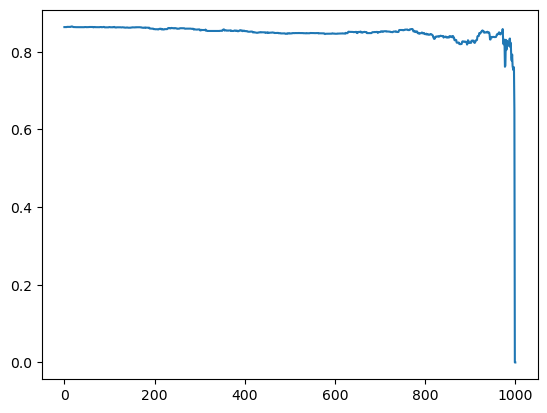

In [40]:
from eval import data_removal_f1
from metrics import weighted_acc_drop
acc = data_removal_f1(dic_loaded, X_train_scaled, y_train_imbalanced, X_test_scaled, y_test_imbalanced)
plt.plot(range(len(acc)), acc)
res = weighted_acc_drop(acc)
print("The weighted accuracy drop is {:.3f}".format(res))

In [19]:
train_indices = get_indices(dataloader['train'])
trained_with_flag = train_with_corrupt_flag(dataloader['train'], train_indices)

NameError: name 'loaders' is not defined

In [ ]:
%matplotlib inline
calibrated_gradient = lava.compute_values_and_visualize(dual_sol, trained_with_flag, training_size, portion)

In [1]:
import pickle
with open('balanced_train.pkl', 'rb') as f:
    X_train_balanced, y_train_balanced = pickle.load(f)
with open('balanced_test.pkl', 'rb') as f:
    X_test_balanced, y_test_balanced = pickle.load(f)
print(X_train_balanced.shape, y_train_balanced.shape)
print(X_test_balanced.shape, y_test_balanced.shape)

(1000, 28, 28) (1000,)
(4000, 28, 28) (4000,)


In [3]:
import lava
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.autograd import Variable

import matplotlib.pyplot as plt
from torch import tensor
from torchvision import datasets, transforms
import pandas as pd
import numpy as n

from torch.utils.data import Dataset, TensorDataset, DataLoader

c:\Users\21520\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\21520\PycharmProjects\LAVA\LAVA\otdd\pytorch\utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True


In [4]:
X_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
batch_size = 8
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X_tensor = torch.tensor(X_test_balanced, dtype= torch.float32)
y_tensor = torch.tensor(y_test_balanced, dtype = torch.long)
dataset = TensorDataset(X_tensor, y_tensor) 
dataloader['test'] = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import pickle

# Định nghĩa mô hình PreActResNet18 như đã thực hiện trước đó
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

# Khởi tạo mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_test = PreActResNet18().to(device)
feature_extractor_name = 'preact_resnet18_test_mnist.pth'
net_test.load_state_dict(torch.load('checkpoint/' + feature_extractor_name, map_location=torch.device('cpu')))
net_test.eval()


PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
  )
  (layer

In [6]:
embedder = net_test.to(device)
embedder.fc = torch.nn.Identity()
for p in embedder.parameters():
    p.requires_grad = False
embedder.to(device)
cuda_num = 0
import torchvision
print(torchvision.__version__)
import torch
print(torch.__version__)
import os
#os.environ["CUDA_VISIBLE_DEVICES"]=str(cuda_num)
#print(os.environ["CUDA_VISIBLE_DEVICES"])
#torch.cuda.set_device(cuda_num)
print("Cuda device: ", torch.cuda.current_device())
print("cude devices: ", torch.cuda.device_count())
device = torch.device('cuda:' + str(cuda_num) if torch.cuda.is_available() else 'cpu')
print(device)
training_size = 1000
valid_size = 200
resize = 32
portion = 0.3

0.18.0
2.3.0
Cuda device:  0
cude devices:  1
cuda:0


In [7]:
from otdd.pytorch.distance_fast import DatasetDistance, FeatureCost, batch_augmented_cost
from otdd.pytorch.wasserstein import pwdist_exact
from functools import partial
from lava import train_with_corrupt_flag, get_indices, values, sort_and_keep_indices
resize = 28
feature_cost = FeatureCost(src_embedding = embedder,
                               src_dim = (1, resize,resize),
                               tgt_embedding = embedder,
                               tgt_dim = (1, resize,resize),
                               p = 2,
                               device='cuda')
dist = DatasetDistance(dataloader['train'], dataloader['test'],
                           inner_ot_method = 'exact',
                           debiased_loss = True,
                           feature_cost = feature_cost,
                           λ_x=1.0, λ_y=1.0,
                           sqrt_method = 'spectral',
                           sqrt_niters=10,
                           precision='single',
                           p = 2, entreg = 1e-1,
                           device='cuda')

In [8]:
W = dist._get_label_distances().to(torch.device(device))
import geomloss
import numpy as np
cost_geomloss = partial(
                batch_augmented_cost,
                W=W,
                λ_x=dist.λ_x,
                λ_y=dist.λ_y,
                feature_cost=dist.feature_cost
            )

loss = geomloss.SamplesLoss(
                loss=dist.loss, p=dist.p,
                cost=cost_geomloss,
                debias=dist.debiased_loss,
                blur=dist.entreg**(1 / dist.p),
                backend='tensorized'
            )
maxsamples = None
if maxsamples and dist.X1.shape[0] > maxsamples:
    idxs_1 = sorted(np.random.choice(
    dist.X1.shape[0], maxsamples, replace=False))
else:
    idxs_1 = np.s_[:]  # hack to get a full slice

if maxsamples and dist.X2.shape[0] > maxsamples:
    idxs_2 = sorted(np.random.choice(
    dist.X2.shape[0], maxsamples, replace=False))
else:
    idxs_2 = np.s_[:]  # hack to get a full slice
Z1 = torch.cat((dist.X1[idxs_1],
                dist.Y1[idxs_1].type(dist.X1.dtype).unsqueeze(1)), -1)
Z2 = torch.cat((dist.X2[idxs_2],
                dist.Y2[idxs_2].type(dist.X2.dtype).unsqueeze(1)), -1)
Z1 = Z1.to(device)
Z2 = Z2.to(device)
print(Z1.shape, Z2.shape)

  0%|          | 0/125 [00:00<?, ?it/s]

load full dataset: torch.Size([1000])


  0%|          | 0/500 [00:00<?, ?it/s]

load full dataset: torch.Size([4000])
2 2
[(0, 1)]
cost function:


  0%|          | 0/1 [00:00<?, ?it/s]

0 1
huhu: torch.Size([500, 784]) torch.Size([500, 784])
1 500 784
torch.Size([1, 500, 100])
1 500 784
torch.Size([1, 500, 100])
torch.Size([1, 500, 500])
1 500 784
torch.Size([1, 500, 100])
1 500 784
torch.Size([1, 500, 100])
torch.Size([1, 500, 500])
was: tensor(2.6559e+09, device='cuda:0')
2 2
[(0, 1)]
cost function:


  0%|          | 0/1 [00:00<?, ?it/s]

0 1
huhu: torch.Size([2000, 784]) torch.Size([2000, 784])
1 2000 784
torch.Size([1, 2000, 100])
1 2000 784
torch.Size([1, 2000, 100])
torch.Size([1, 2000, 2000])
1 2000 784
torch.Size([1, 2000, 100])
1 2000 784
torch.Size([1, 2000, 100])
torch.Size([1, 2000, 2000])
was: tensor(9.9594e+08, device='cuda:0')
2 2
[(0, 0), (0, 1), (1, 0), (1, 1)]
cost function:


  0%|          | 0/4 [00:00<?, ?it/s]

0 0
huhu: torch.Size([500, 784]) torch.Size([2000, 784])
1 500 784
torch.Size([1, 500, 100])
1 2000 784
torch.Size([1, 2000, 100])
torch.Size([1, 500, 2000])
1 2000 784
torch.Size([1, 2000, 100])
1 500 784
torch.Size([1, 500, 100])
torch.Size([1, 2000, 500])
was: tensor(4.7015e+09, device='cuda:0')
0 1
huhu: torch.Size([500, 784]) torch.Size([2000, 784])
1 500 784
torch.Size([1, 500, 100])
1 2000 784
torch.Size([1, 2000, 100])
torch.Size([1, 500, 2000])
1 2000 784
torch.Size([1, 2000, 100])
1 500 784
torch.Size([1, 500, 100])
torch.Size([1, 2000, 500])
was: tensor(2.5343e+09, device='cuda:0')
1 0
huhu: torch.Size([500, 784]) torch.Size([2000, 784])
1 500 784
torch.Size([1, 500, 100])
1 2000 784
torch.Size([1, 2000, 100])
torch.Size([1, 500, 2000])
1 2000 784
torch.Size([1, 2000, 100])
1 500 784
torch.Size([1, 500, 100])
torch.Size([1, 2000, 500])
was: tensor(6.5910e+09, device='cuda:0')
1 1
huhu: torch.Size([500, 784]) torch.Size([2000, 784])
1 500 784
torch.Size([1, 500, 100])
1 2000 

In [9]:
with torch.no_grad():
    loss.debias = False
    loss.potentials = True
    print(Z1.shape, Z2.shape)
    F_i, G_j = loss(Z1, Z2)

torch.Size([1000, 785]) torch.Size([4000, 785])
Z1 shape in batch:  torch.Size([1, 1000, 785])
Z2 shape in batch:  torch.Size([1, 4000, 785])
1 1000 784
torch.Size([1, 1000, 100])
1 4000 784
torch.Size([1, 4000, 100])
torch.Size([1, 1000, 4000])
torch.Size([1, 1000, 4000])
Gia tri M: tensor([[[6, 6, 7,  ..., 7, 7, 7],
         [2, 2, 3,  ..., 3, 3, 3],
         [6, 6, 7,  ..., 7, 7, 7],
         ...,
         [6, 6, 7,  ..., 7, 7, 7],
         [2, 2, 3,  ..., 3, 3, 3],
         [6, 6, 7,  ..., 7, 7, 7]]], device='cuda:0')
torch.Size([1, 1000, 4000])
torch.Size([1, 1000, 4000])
gia tri D: tensor([[[8.1817e+10, 2.5932e+12, 2.9280e+13,  ..., 1.6112e+13,
          1.1389e+13, 1.6589e+13],
         [9.0699e+12, 1.2609e+12, 7.1840e+12,  ..., 1.6479e+12,
          4.1574e+11, 1.8018e+12],
         [2.9469e+12, 3.3708e+10, 1.5806e+13,  ..., 6.6494e+12,
          3.7614e+12, 6.9566e+12],
         ...,
         [3.2776e+13, 1.4712e+13, 2.0984e+09,  ..., 2.0478e+12,
          4.2854e+12, 1.8837e+

In [10]:
π = [F_i, G_j]
dual_sol = π
for i in range(len(dual_sol)):
    dual_sol[i] = dual_sol[i].to('cpu')
calibrated_gradient = values(dual_sol, training_size)
with open('calibrated_gradient.pkl', 'wb') as f:
    pickle.dump(calibrated_gradient, f)

In [11]:
with open('calibrated_gradient.pkl', 'rb') as f:
    loaded = pickle.load(f)
print(loaded)

[-105436540.0, 25310208.0, -153372000.0, 11471168.0, 206820480.0, 55940290.0, -161260160.0, 34693250.0, 10488832.0, 1445568.0, -142162110.0, -104090620.0, -9019072.0, 35934464.0, 27531392.0, -186393250.0, -124985380.0, 158693310.0, 77251580.0, 87436930.0, -128984510.0, -10882752.0, 83981440.0, -61718910.0, 70794430.0, 139254720.0, -127395710.0, 123487420.0, 28170496.0, -196940260.0, -79057860.0, 47008000.0, 13428416.0, 104150460.0, 51729470.0, 43572736.0, 40529790.0, -110372480.0, -177694200.0, -188921500.0, 25147648.0, 389410370.0, -187263740.0, -157860900.0, 33210368.0, 12548672.0, -179210720.0, 20706112.0, 52150144.0, -170180510.0, 33033600.0, -113388670.0, -62483200.0, 222385150.0, -78486590.0, -145819100.0, -181676740.0, -152524640.0, -150749380.0, 39723390.0, 377143870.0, -126252990.0, 919648400.0, -126964420.0, 48309056.0, 143271800.0, 130538560.0, 20231488.0, 27271552.0, -131344800.0, -125991940.0, 21103808.0, -160133380.0, 69509440.0, -150001700.0, -162275170.0, 471608830.0, -

In [13]:
# Trích xuất đặc trưng từ các tập dữ liệu
# Hàm để trích xuất đặc trưng từ X
def extract_features(net, X):
    X = torch.tensor(X).float().unsqueeze(1)  # Thêm chiều để có kích thước [N, 1, 28, 28]
    X = X.repeat(1, 3, 1, 1).to(device)  # Chuyển thành [N, 3, 28, 28]
    with torch.no_grad():
        features = net(X)
    return features.cpu().numpy()
X_train_features = extract_features(net_test, X_train_balanced)
X_test_features = extract_features(net_test, X_test_balanced)

# Lưu các đặc trưng đã trích xuất
with open('balanced_train_features.pkl', 'wb') as f:
    pickle.dump((X_train_features, y_train_balanced), f)
with open('balanced_test_features.pkl', 'wb') as f:
    pickle.dump((X_test_features, y_test_balanced), f)

In [14]:
import pickle

# Load lại các đặc trưng đã lưu cho tập huấn luyện
with open('balanced_train_features.pkl', 'rb') as f:
    X_train_features_loaded, y_train_loaded = pickle.load(f)


# Load lại các đặc trưng đã lưu cho tập kiểm tra (test)
with open('balanced_test_features.pkl', 'rb') as f:
    X_test_features_loaded, y_test_loaded = pickle.load(f)

# Kiểm tra kích thước để đảm bảo rằng dữ liệu đã được tải đúng
print(f"X_train_features_loaded shape: {X_train_features_loaded.shape}")
print(f"y_train_loaded shape: {y_train_loaded.shape}")
print(f"X_test_features_loaded shape: {X_test_features_loaded.shape}")
print(f"y_test_loaded shape: {y_test_loaded.shape}")

X_train_features_loaded shape: (1000, 100)
y_train_loaded shape: (1000,)
X_test_features_loaded shape: (4000, 100)
y_test_loaded shape: (4000,)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features_loaded)
X_test_scaled = scaler.transform(X_test_features_loaded)

In [16]:
dic_loaded = {}
for i, l in enumerate(loaded):
    dic_loaded[i] = l
print(dic_loaded)

{0: -105436540.0, 1: 25310208.0, 2: -153372000.0, 3: 11471168.0, 4: 206820480.0, 5: 55940290.0, 6: -161260160.0, 7: 34693250.0, 8: 10488832.0, 9: 1445568.0, 10: -142162110.0, 11: -104090620.0, 12: -9019072.0, 13: 35934464.0, 14: 27531392.0, 15: -186393250.0, 16: -124985380.0, 17: 158693310.0, 18: 77251580.0, 19: 87436930.0, 20: -128984510.0, 21: -10882752.0, 22: 83981440.0, 23: -61718910.0, 24: 70794430.0, 25: 139254720.0, 26: -127395710.0, 27: 123487420.0, 28: 28170496.0, 29: -196940260.0, 30: -79057860.0, 31: 47008000.0, 32: 13428416.0, 33: 104150460.0, 34: 51729470.0, 35: 43572736.0, 36: 40529790.0, 37: -110372480.0, 38: -177694200.0, 39: -188921500.0, 40: 25147648.0, 41: 389410370.0, 42: -187263740.0, 43: -157860900.0, 44: 33210368.0, 45: 12548672.0, 46: -179210720.0, 47: 20706112.0, 48: 52150144.0, 49: -170180510.0, 50: 33033600.0, 51: -113388670.0, 52: -62483200.0, 53: 222385150.0, 54: -78486590.0, 55: -145819100.0, 56: -181676740.0, 57: -152524640.0, 58: -150749380.0, 59: 397233

In [20]:
import operator
sorted_dct = sorted(dic_loaded.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dct)

[(688, 7416444000.0), (325, 1361434100.0), (334, 1192154400.0), (881, 990569600.0), (853, 976954600.0), (62, 919648400.0), (793, 693147800.0), (560, 648020860.0), (982, 643953000.0), (633, 612968800.0), (672, 593849200.0), (381, 587190400.0), (698, 583976700.0), (246, 583571840.0), (329, 573303200.0), (642, 552971000.0), (343, 535015040.0), (833, 508673540.0), (76, 471608830.0), (570, 469521920.0), (506, 441704580.0), (808, 435987700.0), (428, 435132160.0), (934, 427278340.0), (644, 418872130.0), (805, 417549630.0), (862, 415857540.0), (547, 413354000.0), (788, 407853630.0), (983, 404180600.0), (265, 402850000.0), (749, 397199170.0), (225, 393472200.0), (41, 389410370.0), (751, 384530240.0), (782, 383166200.0), (900, 381857470.0), (170, 381835070.0), (60, 377143870.0), (85, 359141700.0), (903, 350674300.0), (949, 334902080.0), (803, 334077000.0), (557, 332948160.0), (955, 322528500.0), (634, 312339400.0), (512, 309764860.0), (638, 302970300.0), (527, 302172540.0), (553, 300880830.0), (

The weighted accuracy drop is 0.067


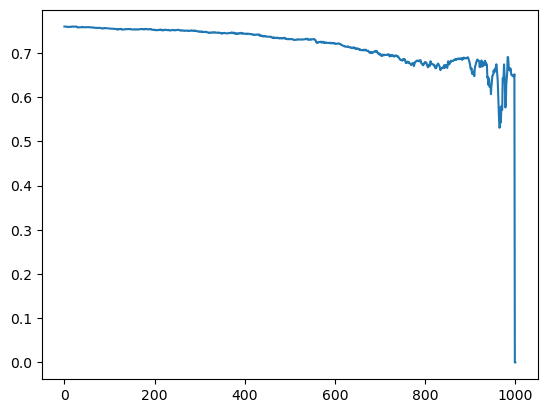

In [19]:
from eval import data_removal_f1
from metrics import weighted_acc_drop
acc = data_removal_f1(dic_loaded, X_train_scaled, y_train_balanced, X_test_scaled, y_test_balanced)
plt.plot(range(len(acc)), acc)
res = weighted_acc_drop(acc)
print("The weighted accuracy drop is {:.3f}".format(res))

In [23]:
with open('vals_mt.pkl', 'rb') as f:
    accs = pickle.load(f)
print(accs)

{0: -0.0004520000000000002, 1: -0.002193999999999999, 2: 0.0009899999999999993, 3: 0.000688, 4: 0.001975999999999998, 5: 0.001773999999999998, 6: -0.0007680000000000006, 7: 0.0007699999999999997, 8: 0.0004660000000000004, 9: 0.0019260000000000006, 10: 0.002362000000000002, 11: 0.0007120000000000026, 12: 0.0012820000000000002, 13: -0.0003839999999999993, 14: 0.0005640000000000003, 15: 0.0017879999999999975, 16: 0.0010200000000000007, 17: 0.0007939999999999988, 18: 0.0009019999999999995, 19: 0.0015500000000000008, 20: 0.0001859999999999987, 21: 0.0009160000000000006, 22: 0.00048200000000000033, 23: -0.0008460000000000009, 24: 0.0017059999999999996, 25: 0.0016219999999999993, 26: 0.0006419999999999998, 27: 0.0011360000000000025, 28: 0.00029400000000000064, 29: 4.199999999999945e-05, 30: 0.00041400000000000106, 31: -0.001978000000000001, 32: -0.0005200000000000003, 33: 0.0016099999999999999, 34: 0.0008940000000000005, 35: 0.0015059999999999993, 36: 0.0008240000000000006, 37: 0.001601999999

In [24]:
import operator
sorted_dct = sorted(accs.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dct)

[(372, 0.0075200000000000015), (287, 0.0044579999999999976), (898, 0.0039480000000000045), (307, 0.003934000000000007), (740, 0.003684), (684, 0.003653999999999998), (557, 0.0036379999999999984), (391, 0.003610000000000004), (394, 0.003530000000000004), (739, 0.003487999999999998), (270, 0.0032039999999999985), (626, 0.003086000000000001), (828, 0.003075999999999998), (230, 0.0030720000000000022), (178, 0.0030559999999999993), (149, 0.003), (567, 0.003), (249, 0.0029219999999999966), (922, 0.002907999999999998), (992, 0.002895999999999999), (89, 0.002871999999999996), (411, 0.002822000000000002), (166, 0.002816), (650, 0.002792000000000001), (529, 0.002786000000000002), (885, 0.0027259999999999984), (631, 0.002672000000000001), (213, 0.002654), (70, 0.0026360000000000008), (331, 0.002618), (931, 0.0025979999999999996), (906, 0.0025960000000000015), (758, 0.0025720000000000022), (343, 0.002572), (226, 0.002569999999999996), (596, 0.0025460000000000005), (742, 0.002544000000000001), (432

The weighted accuracy drop is 0.452


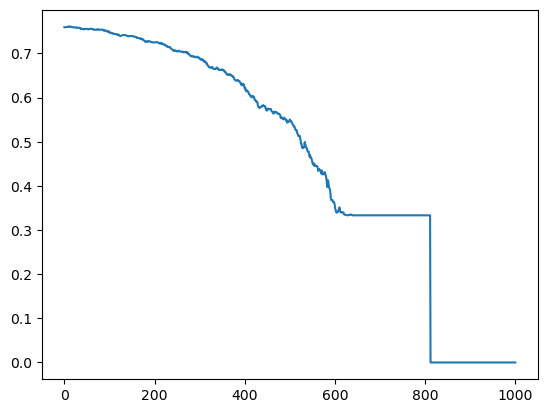

In [26]:
from eval import data_removal_f1
from metrics import weighted_acc_drop
acc = data_removal_f1(accs, X_train_scaled, y_train_balanced, X_test_scaled, y_test_balanced)
plt.plot(range(len(acc)), acc)
res = weighted_acc_drop(acc)
print("The weighted accuracy drop is {:.3f}".format(res))

In [27]:
print(acc)

[0.7594814520847701, 0.7592399840937211, 0.7592399840937211, 0.7595227571735715, 0.760046797169232, 0.760046797169232, 0.760046797169232, 0.7603690115851012, 0.760872438031351, 0.760872438031351, 0.7611340569662554, 0.7602057097838649, 0.7609509020832248, 0.7601862796480878, 0.760428169218241, 0.760428169218241, 0.7601862796480878, 0.759499033467873, 0.7597218157306604, 0.7600021735652206, 0.7592570173466388, 0.7592760320992962, 0.7590339626286324, 0.7585871918937603, 0.7588479267742609, 0.7589028546316828, 0.7586605054704876, 0.7593875167754609, 0.7586785235952075, 0.7579512724241463, 0.7579512724241463, 0.7579512724241463, 0.7577088303569721, 0.7579512724241463, 0.7582291921914562, 0.7575190302017586, 0.7555607879559549, 0.7555607879559549, 0.7558034368405185, 0.7562886938807608, 0.7555778583433014, 0.7550924290592252, 0.7553520506597081, 0.7553520506597081, 0.7546237074813209, 0.7553520506597081, 0.7555948035637191, 0.755837542540033, 0.7556116236687757, 0.7558544078452116, 0.755611